# Prediction of Closing Price Using LSTM

In [1]:
import os
import random as rn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [2]:
# Source: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
def build_xy(data, n_day):
    '''Build X and y.'''
    x = []
    y = []
    for i in range(n_day, data.shape[0]):
        x.append(data[i-n_day:i, :4])
        y.append(data[i, 3])
    x, y = np.array(x), np.array(y)
    x = x.reshape(x.shape[0], x.shape[1], 4)
    return x, y

In [4]:
def get_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [5]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
def predict_lstm(ticker, 
                 start_date='2000-01-01', 
                 end_date=datetime.now(), 
                 date_split='2016-01-01',
                 n_day=60):
    
    # get data 
    data = pdr.get_data_yahoo(tickers=[ticker], start=start_date, end=end_date)
    # apply log transformation
    data = np.log1p(data)
    index_all = data.index[n_day:]
    # split it into train and test
    data_tr = data.loc[:date_split].values
    data_te = data.loc[date_split:].values
    data_te = np.concatenate([data_tr[-n_day:], data_te])
    
    # build x, y
    X_train, y_train = build_xy(data_tr, n_day)
    X_test, y_test = build_xy(data_te, n_day)
    y_all = np.concatenate([y_train, y_test])
    
    # get model
    model = get_lstm(input_shape=(X_train.shape[1], X_train.shape[2]))
    # fit
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
    # predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
   
    # calculate error
    y_train_error = rmse(y_train, y_train_pred)
    y_test_error = rmse(y_test, y_test_pred)
    print("Training Error: {:.3f}, Test Error: {:.3f}".format(y_train_error, y_test_error))
    
    return y_all, index_all, y_train_pred, y_test_pred

In [7]:
def plot_predict(y_all, index_all, y_train_pred, y_test_pred, save_path=None, title=None):
    y_all = pd.Series(y_all.flatten(), index=index_all)
    y_train_pred = pd.Series(y_train_pred.flatten(), index=index_all[:y_train_pred.shape[0]])
    y_test_pred = pd.Series(y_test_pred.flatten(), index=index_all[-y_test_pred.shape[0]:])
    plt.figure(figsize=(8,5))
    plt.plot(y_all, label='True')
    plt.plot(y_train_pred, label='Training Prediction')
    plt.plot(y_test_pred, label='Test Prediction')
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("LOG(Closing Price)")
    if title:
        plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

## Credit Suisse

In [16]:
y_all, index_all, y_train_pred, y_test_pred = predict_lstm('CS')

[*********************100%***********************]  1 of 1 downloaded
Training Error: 0.062, Test Error: 0.183


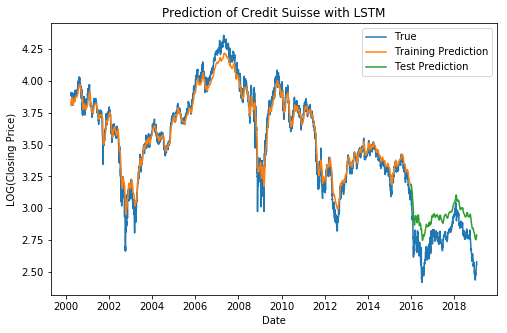

In [17]:
save_path = os.path.join("figure", "lstm_pred_cs.jpg")
title = "Prediction of Credit Suisse with LSTM"
plot_predict(y_all, index_all, y_train_pred, y_test_pred, save_path, title)

## Novartis

In [14]:
y_all, index_all, y_train_pred, y_test_pred = predict_lstm('NVS')

[*********************100%***********************]  1 of 1 downloaded
Training Error: 0.046, Test Error: 0.040


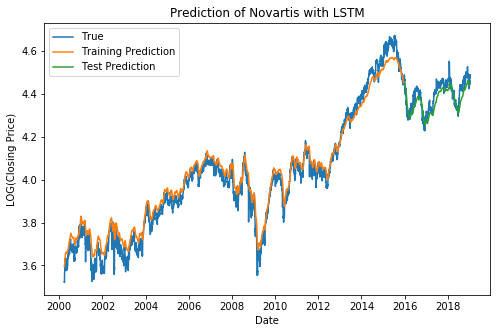

In [15]:
save_path = os.path.join("figure", "lstm_pred_novartis.jpg")
title = "Prediction of Novartis with LSTM"
plot_predict(y_all, index_all, y_train_pred, y_test_pred, save_path, title)